# Phần 1: Khai báo thư viện và cố định phiên bản

In [ ]:
# Gỡ bỏ các phiên bản cũ
!pip uninstall -y numpy pandas seaborn onnxruntime onnx torch catboost optuna skl2onnx sklearn-genetic-opt

# (Tùy chọn) Nâng pip
!pip install --upgrade pip

# Cài đặt lại với các phiên bản đã cân chỉnh
!pip install \
  numpy==1.26.4 \
  pandas==2.2.2 \
  seaborn==0.13.2 \
  "protobuf==3.20.3" \
  onnxruntime==1.20.1 \
  onnx==1.17.0 \
  torch==2.6.0 \
  catboost==1.2.8 \
  optuna==4.2.1 \
  skl2onnx==1.17.0 \
  sklearn-genetic-opt==0.11.1


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: seaborn 0.13.2
Uninstalling seaborn-0.13.2:
  Successfully uninstalled seaborn-0.13.2
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires pandas, which is not installed.
fastai 2.7.19 requires torch<2.7,>=1.10, which is not installed.
INFO: pip is looking at multipl

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import random, onnx
import onnxruntime as ort
import optuna

from gym.spaces import Box, Discrete
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from onnx import helper, numpy_helper
from sklearn.impute import SimpleImputer
from optuna.exceptions import TrialPruned
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical, Continuous

# Phần 2: Nhập và định nghĩa Dataset.

In [ ]:

# ---------------------------
# 1. Đọc dữ liệu từ CSV và xử lý
data = pd.read_csv('/content/0.3457_4.csv', delimiter=',', encoding="utf-8")
data.set_index('Datetime', inplace=True)



# Check for NaN values in the entire DataFrame
nan_check = data.isnull().values.any()

if nan_check:
    print("DataFrame contains NaN values.")
    # Get the total number of NaN values
    total_nan = data.isnull().sum().sum()
    print(f"Total number of NaN values: {total_nan}")

    # Get the number of NaN values in each column
    nan_per_column = data.isnull().sum()
    print("Number of NaN values in each column:")
    print(nan_per_column)
else:
    print("DataFrame does not contain NaN values.")

print('\n')

# Chọn 1 trong 2 cách xử lý NaN:
#data.fillna(0, inplace=True)
data.dropna(inplace=True)

data.info()

# Nếu cần cân bằng thì phải cân bằng tại đây

# ---------------------------
# Cơ chế chuyển đổi Profit
original_profit = data['Profit'].copy()

data['Profit'] = data['Profit'].apply(lambda x: 1 if x > 0 else -1)
print(data['Profit'].value_counts(), '\n')

# ---------------------------
# 5. Đặt seed cố định để đảm bảo tính đồng bộ
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

DataFrame contains NaN values.
Total number of NaN values: 12
Number of NaN values in each column:
c0                             0
h0                             0
l0                             0
o0                             0
v0                             0
abs(c0-o0)/abs(h0-l0)          0
(c0-c1)/atr14                  0
c0-c1                          0
Spread                         0
(h0-c0)/(h0-l0)                3
(h0-o0)/(h0-l0)                3
(l0-c0)/(h0-l0)                3
(l0-o0)/(h0-l0)                3
atr14                          0
ema20                          0
bb20dev2_upper                 0
bb20dev2_lower                 0
close_ratio                    0
price_return                   0
volume_change_ratio            0
bb20dev2_width                 0
ema20_slope                    0
rsi14                          0
ema100                         0
ema200                         0
body_atr14_ratio               0
close_above_ema20              0
rsi14_over

# Phần 3: *EDA

## Phần 3 - EDA 1: Correlation

Tương quan của các cột với 'Profit':
Spread                         0.036145
abs(c0-o0)/abs(h0-l0)          0.028683
v0                             0.021557
atr14                          0.020433
rsi14_overbought               0.009195
(h0-c0)/(h0-l0)                0.007053
(l0-c0)/(h0-l0)                0.007053
bb20dev2_width                 0.006451
price_breaks_upper_bb20dev2    0.004484
price_breaks_lower_bb20dev2    0.003364
ema20_slope                    0.002134
close_ratio                   -0.007615
price_return                  -0.007615
body_atr14_ratio              -0.010494
c0-c1                         -0.011667
volume_change_ratio           -0.012088
(l0-o0)/(h0-l0)               -0.013003
(h0-o0)/(h0-l0)               -0.013003
(c0-c1)/atr14                 -0.013204
close_above_ema20             -0.013216
rsi14                         -0.014052
ema100                        -0.030027
bb20dev2_upper                -0.030205
h0                            -0.030245
ema

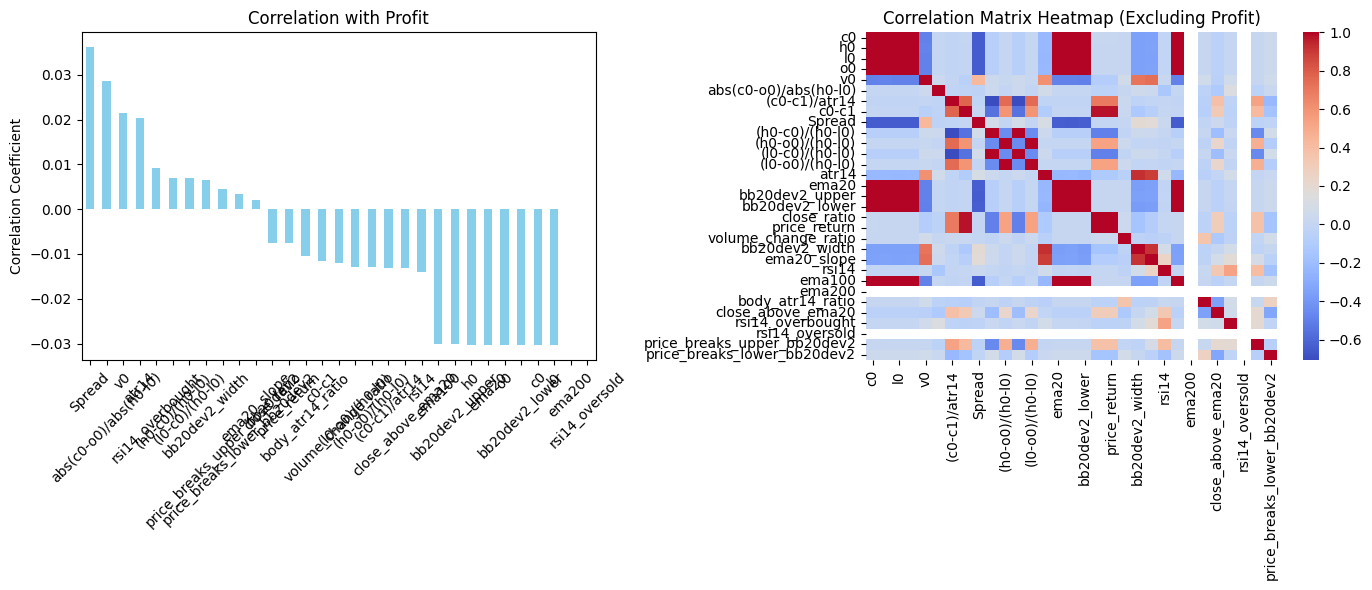

In [ ]:
# Tính ma trận tương quan
corr_matrix = data.corr()

# Lọc bỏ cột 'Profit' khỏi corr_matrix['Profit']
corr_with_profit = corr_matrix['Profit'].drop('Profit')

# In ra độ tương quan của các feature so với cột "Profit" (đã loại bỏ 'Profit')
print("Tương quan của các cột với 'Profit':")
print(corr_with_profit.sort_values(ascending=False))

# Tạo figure và subplot
plt.figure(figsize=(14, 6))

# Subplot 1: Biểu đồ cột cho corr_with_profit
plt.subplot(1, 2, 1)  # 1 hàng, 2 cột, subplot thứ 1
corr_with_profit.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Correlation with Profit")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45)

# Subplot 2: Heatmap của ma trận tương quan (đã loại bỏ 'Profit')
plt.subplot(1, 2, 2)  # 1 hàng, 2 cột, subplot thứ 2
sns.heatmap(corr_matrix.drop('Profit', axis=0).drop('Profit', axis=1), annot=False, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap (Excluding Profit)")

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

# Phần 4: MAIN REPLAY

GLOBAL SCALER SETTING

In [ ]:
# ====================================================================================
scaler = MinMaxScaler()

# Preparing the data
X = data.drop("Profit", axis=1)  # Features
y = data["Profit"]  # Target variable

GLOBAL_TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=GLOBAL_TEST_SIZE, random_state=42, shuffle=False)


# ====================================================================================

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_cumsum_prediction(model, X_test, original_profit_test):
    """
    Trả về cumulative sum của profit gốc cho các mẫu mà model dự đoán = 1.

    Args:
      - model: bất cứ object nào có .predict(X) → array nhị phân {0,1}
      - X_test: DataFrame hoặc array chứa đặc trưng test
      - original_profit_test: Series hoặc array profit gốc, cùng index với X_test

    Returns:
      - cumsum: 1D numpy array chứa cumulative sum
    """
    # dự đoán
    y_pred = model.predict(X_test)
    # score = profit nếu y_pred==1, ngược lại 0
    # nếu original_profit_test là Series, đảm bảo cùng index
    profits = original_profit_test.to_numpy() if hasattr(original_profit_test, "to_numpy") else np.array(original_profit_test)
    score = np.where(y_pred == 1, profits, 0)
    return np.cumsum(score)


def plot_cumsum(model, X_test, original_profit_test, label="Model"):
    """
    Vẽ biểu đồ cumulative sum giữa dự đoán của model và profit gốc.

    Args:
      - model: bất cứ object nào có .predict(X) → array nhị phân {0,1}
      - X_test: DataFrame hoặc array chứa đặc trưng test
      - original_profit_test: Series hoặc array profit gốc, cùng index với X_test
      - label: chuỗi nhãn cho đường của model
    """
    # cumulative sum từ model
    cumsum_pred = compute_cumsum_prediction(model, X_test, original_profit_test)
    # cumulative sum mặc định của profit gốc
    profits = original_profit_test.to_numpy() if hasattr(original_profit_test, "to_numpy") else np.array(original_profit_test)
    cumsum_orig = np.cumsum(profits)

    # vẽ
    plt.figure(figsize=(12, 6))
    plt.plot(cumsum_pred, label=f"{label} (dự đoán)", linewidth=2)
    plt.plot(cumsum_orig,   label="Original Profit (cumsum)", linestyle="--", color="k", linewidth=1.5)
    plt.xlabel("Chỉ số mẫu")
    plt.ylabel("Cumulative Sum (Điểm)")
    plt.title(f"Cumulative Sum so sánh: {label} vs Original")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Phần 4 - MAIN REPLAY: RF

In [ ]:

# ---------------------------
# 2. Random Forest without PCA
rf_pipeline = Pipeline([
    ("scaler", scaler),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("\nRandom Forest without PCA:")
print(classification_report(y_test, y_pred_rf))



Random Forest without PCA:
              precision    recall  f1-score   support

          -1       0.62      0.85      0.72       237
           1       0.33      0.13      0.18       141

    accuracy                           0.58       378
   macro avg       0.48      0.49      0.45       378
weighted avg       0.51      0.58      0.52       378



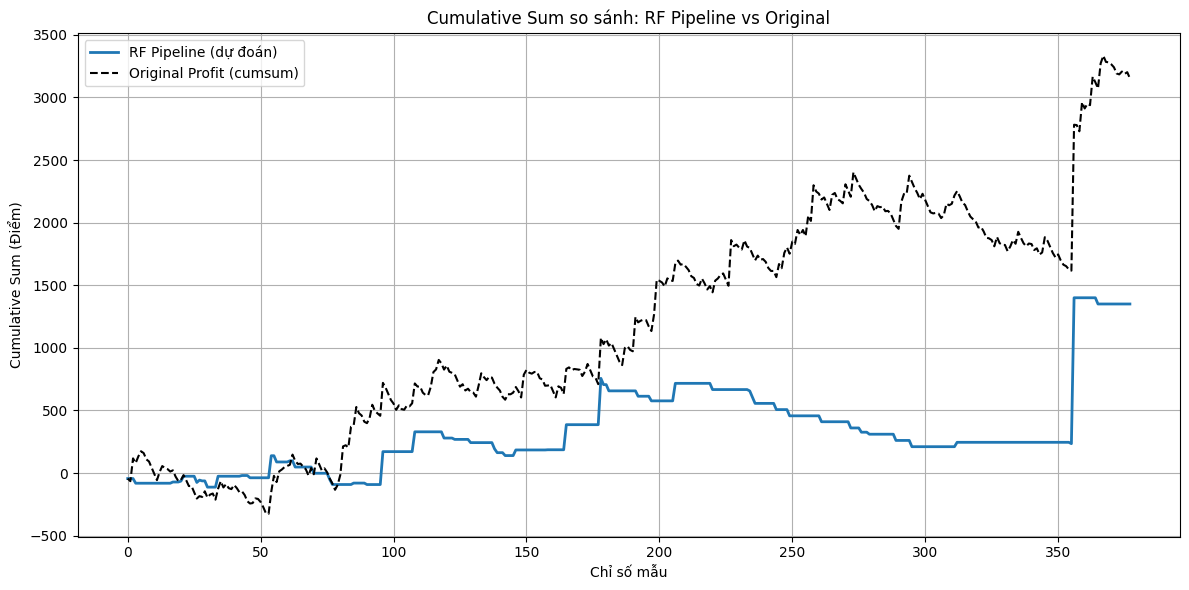

In [ ]:
# giả sử bạn đã có model rf_pipeline, X_test, original_profit_test như trước
# Giả sử X_test, y_test đã được tách từ dữ liệu ban đầu và original_profit_test được lấy theo index:
original_profit_test = original_profit.loc[y_test.index]
plot_cumsum(rf_pipeline, X_test, original_profit_test, label="RF Pipeline")


### Phần 4 - MAIN REPLAY: Features Importacne

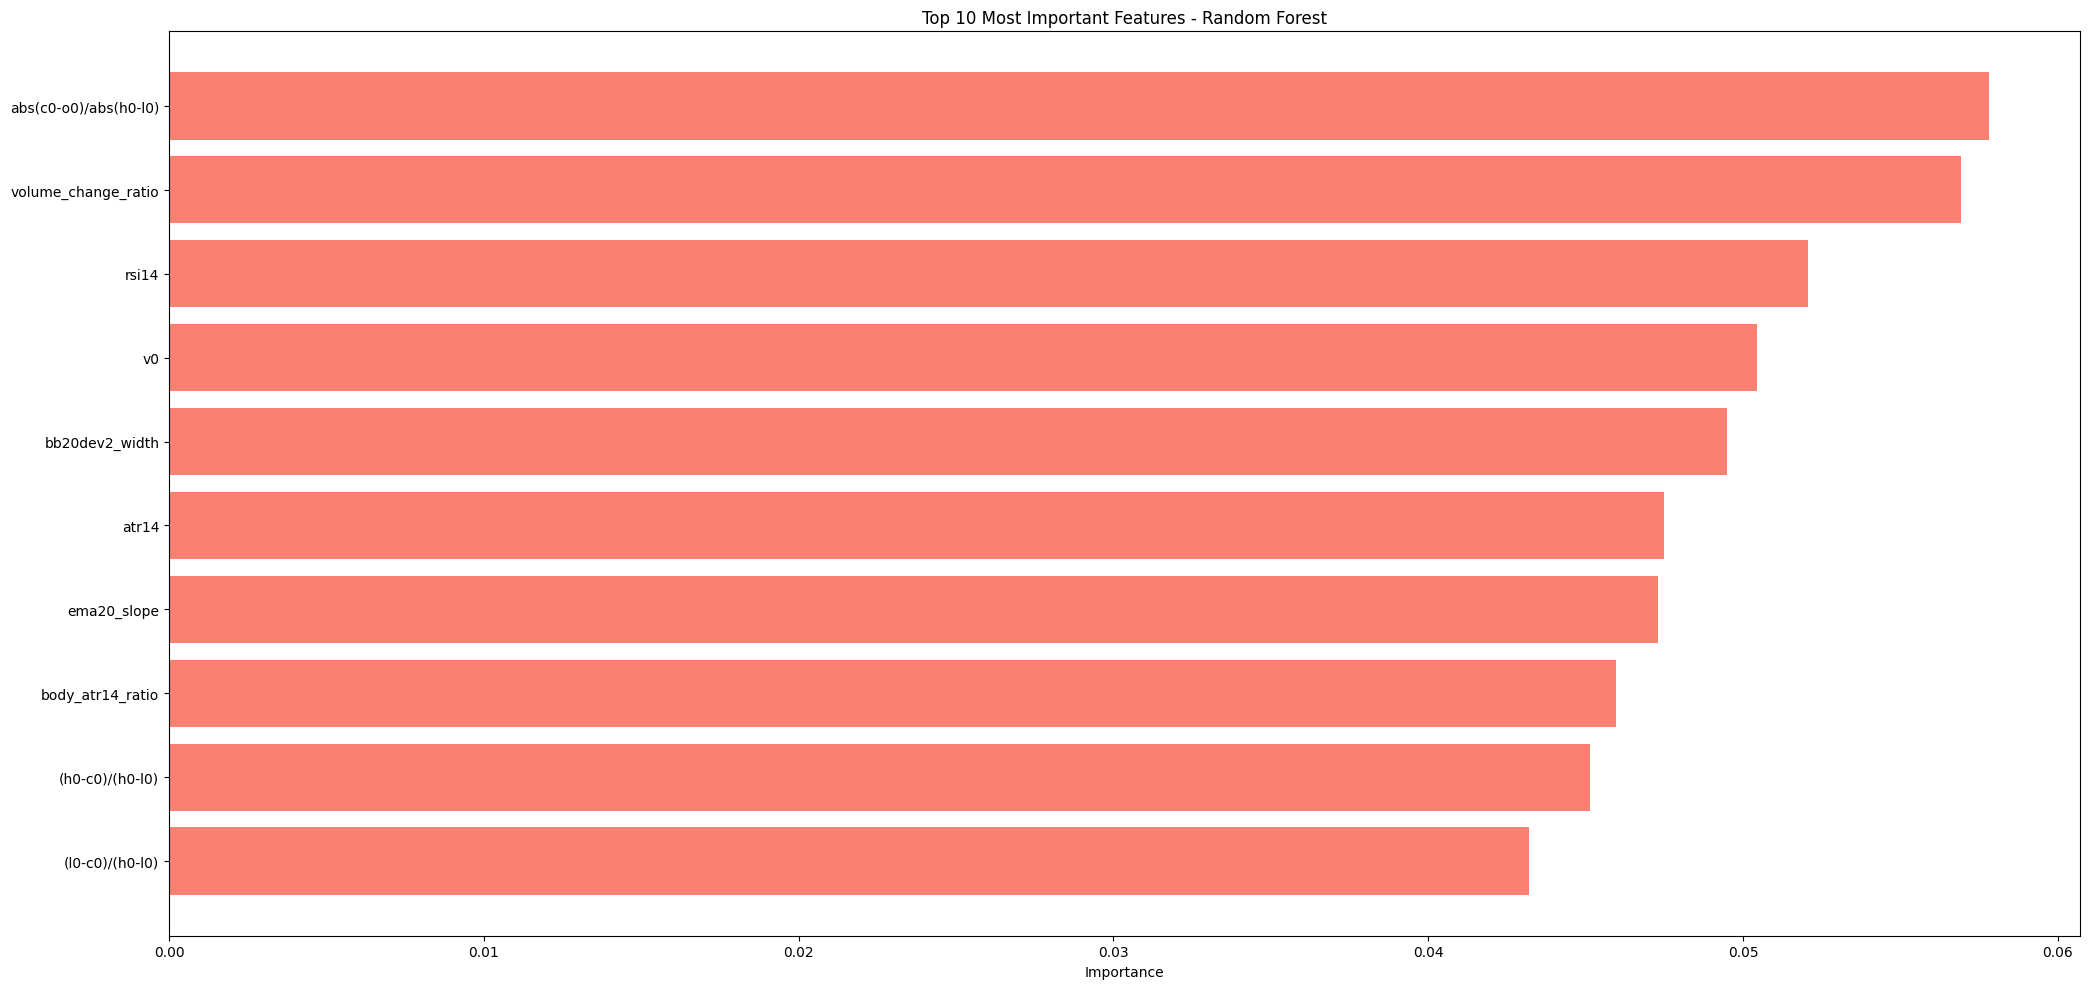

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

num_components = 0

# Lấy feature importances từ Random Forest
rf_classifier = rf_pipeline.named_steps['classifier']
feature_importances = rf_classifier.feature_importances_
feature_importance_sorted = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)
top_features_rf = feature_importance_sorted[:10]
rf_names = [f[0] for f in top_features_rf]
rf_importances = [f[1] for f in top_features_rf]

fig = plt.figure(figsize=(21, 10))
# Vẽ biểu đồ Feature Importance của Random Forest trên hàng dưới
gs = gridspec.GridSpec(1, 1)  # Added this line to create a gridspec

ax_rf = fig.add_subplot(gs[0])
ax_rf.barh(rf_names, rf_importances, color='salmon')
ax_rf.invert_yaxis()
ax_rf.set_title("Top 10 Most Important Features - Random Forest")
ax_rf.set_xlabel("Importance")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_cumsum_prediction(model, X_test, original_profit_test):
    # dự đoán
    y_pred = model.predict(X_test)
    # score = profit nếu y_pred==1, ngược lại 0
    # nếu original_profit_test là Series, đảm bảo cùng index
    profits = original_profit_test.to_numpy() if hasattr(original_profit_test, "to_numpy") else np.array(original_profit_test)
    score = np.where(y_pred == 1, profits, 0)
    return np.cumsum(score)


def plot_cumsum(model, X_test, original_profit_test, label="Model"):
    # cumulative sum từ model
    cumsum_pred = compute_cumsum_prediction(model, X_test, original_profit_test)
    # cumulative sum mặc định của profit gốc
    profits = original_profit_test.to_numpy() if hasattr(original_profit_test, "to_numpy") else np.array(original_profit_test)
    cumsum_orig = np.cumsum(profits)

    # vẽ
    plt.figure(figsize=(12, 6))
    plt.plot(cumsum_pred, label=f"{label} (dự đoán)", linewidth=2)
    plt.plot(cumsum_orig,   label="Original Profit (cumsum)", linestyle="--", color="k", linewidth=1.5)
    plt.xlabel("Chỉ số mẫu")
    plt.ylabel("Cumulative Sum (Điểm)")
    plt.title(f"Cumulative Sum so sánh: {label} vs Original")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Phần 4 - MAIN REPLAY: CatBoost Optuna

In [ ]:
import pandas as pd
import optuna
from catboost import CatBoostClassifier
from catboost.utils import convert_to_onnx_object
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score

import onnx
from onnx.helper import get_attribute_value
import onnxruntime as rt
from skl2onnx import convert_sklearn, update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from skl2onnx.common.data_types import FloatTensorType, Int64TensorType, guess_tensor_type
from skl2onnx._parse import _apply_zipmap, _get_sklearn_operator_name

# --------------------------------------------------------------------
def skl2onnx_parser_castboost_classifier(scope, model, inputs, custom_parsers=None):
    options = scope.get_options(model, dict(zipmap=True))
    no_zipmap = isinstance(options["zipmap"], bool) and not options["zipmap"]

    alias = _get_sklearn_operator_name(type(model))
    this_operator = scope.declare_local_operator(alias, model)
    this_operator.inputs = inputs

    label_variable = scope.declare_local_variable("label", Int64TensorType())
    prob_dtype = guess_tensor_type(inputs[0].type)
    probability_tensor_variable = scope.declare_local_variable("probabilities", prob_dtype)
    this_operator.outputs.append(label_variable)
    this_operator.outputs.append(probability_tensor_variable)
    probability_tensor = this_operator.outputs

    if no_zipmap:
        return probability_tensor

    return _apply_zipmap(options["zipmap"], scope, model, inputs[0].type, probability_tensor)


def skl2onnx_convert_catboost(scope, operator, container):
    """
    Chuyển đổi CatBoost sang ONNX. CatBoost trả về ONNX graph 2 node (prob và label)
    Prob sẽ được xoá ở phần Onnx export
    """
    onx = convert_to_onnx_object(operator.raw_operator)
    opsets = {d.domain: d.version for d in onx.opset_import}
    if "" in opsets and opsets[""] >= container.target_opset:
        raise RuntimeError("CatBoost uses an opset more recent than the target one.")
    if len(onx.graph.initializer) > 0 or len(onx.graph.sparse_initializer) > 0:
        raise NotImplementedError("CatBoost returns model initializers. This option is not implemented yet.")
    if (len(onx.graph.node) not in (1, 2) or
        not onx.graph.node[0].op_type.startswith("TreeEnsemble") or
        (len(onx.graph.node) == 2 and onx.graph.node[1].op_type != "ZipMap")):
        types = ", ".join(map(lambda n: n.op_type, onx.graph.node))
        raise NotImplementedError(
            f"CatBoost returns {len(onx.graph.node)} nodes (types={types}). This option is not implemented yet."
        )
    node = onx.graph.node[0]
    atts = {}
    for att in node.attribute:
        atts[att.name] = get_attribute_value(att)
    container.add_node(
        node.op_type,
        [operator.inputs[0].full_name],
        [operator.outputs[0].full_name, operator.outputs[1].full_name],
        op_domain=node.domain,
        op_version=opsets.get(node.domain, None),
        **atts,
    )

# Cập nhật converter cho CatBoostClassifier
update_registered_converter(
    CatBoostClassifier,
    "CatBoostCatBoostClassifier",
    calculate_linear_classifier_output_shapes,
    skl2onnx_convert_catboost,
    parser=skl2onnx_parser_castboost_classifier,
    options={"nocl": [True, False], "zipmap": [True, False, "columns"]},
)


# --------------------------------------------------------------------


X_alpha, X_remaining, y_alpha, y_remaining = train_test_split(X, y, test_size= 0.4, random_state=42, shuffle=False)
X_beta, X_gamma, y_beta, y_gamma = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42, shuffle=False)

# Hàm objective sử dụng weighted F1 Score làm chỉ số tối ưu (huấn luyện trên "alpha", đánh giá trên "beta")
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'verbose': 0,
        'random_state': 42
    }
    model = CatBoostClassifier(**params)
    model.fit(X_alpha, y_alpha, eval_set=(X_beta, y_beta), early_stopping_rounds=50)
    preds = model.predict(X_beta)
    score = f1_score(y_beta, preds, average='weighted')
    return score

# Tạo study và chạy tối ưu hóa trong 50 trials
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best hyperparameters:", study.best_params)

# Huấn luyện mô hình cuối cùng trên tập "alpha" + "beta" với hyperparameters tốt nhất
X_combo = pd.concat([X_alpha, X_beta])
y_combo = pd.concat([y_alpha, y_beta])
model_cat = CatBoostClassifier(
    iterations=study.best_params['iterations'],
    learning_rate=study.best_params['learning_rate'],
    depth=study.best_params['depth'],
    l2_leaf_reg=study.best_params['l2_leaf_reg'],
    verbose=100,  # Đổi thành 0 nếu không muốn in log
    random_state=42
)
model_cat.fit(X_combo, y_combo)

# Đánh giá trên tập "gamma"
y_pred = model_cat.predict(X_gamma)
print("Classification Report:")
print(classification_report(y_gamma, y_pred))
print("F1 Score:", f1_score(y_gamma, y_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_gamma, y_pred))



[I 2025-04-19 19:44:44,781] A new study created in memory with name: no-name-ab7d0a50-9c00-4060-8dac-ab19334eadd3
[I 2025-04-19 19:45:14,923] Trial 0 finished with value: 0.508496004770622 and parameters: {'iterations': 802, 'learning_rate': 0.0010878173486438428, 'depth': 9, 'l2_leaf_reg': 0.08152091331195388}. Best is trial 0 with value: 0.508496004770622.
[I 2025-04-19 19:45:42,239] Trial 1 finished with value: 0.5075197132423838 and parameters: {'iterations': 668, 'learning_rate': 0.0013154703698064537, 'depth': 10, 'l2_leaf_reg': 0.006129363147642032}. Best is trial 0 with value: 0.508496004770622.
[I 2025-04-19 19:45:44,789] Trial 2 finished with value: 0.5005626276913405 and parameters: {'iterations': 686, 'learning_rate': 0.012850583747821548, 'depth': 8, 'l2_leaf_reg': 0.004430592600725453}. Best is trial 0 with value: 0.508496004770622.
[I 2025-04-19 19:45:46,229] Trial 3 finished with value: 0.5031336858416794 and parameters: {'iterations': 384, 'learning_rate': 0.0619725054

Best hyperparameters: {'iterations': 838, 'learning_rate': 0.03550887337971495, 'depth': 9, 'l2_leaf_reg': 0.0013524475865283924}
0:	learn: 0.6823223	total: 34ms	remaining: 28.4s
100:	learn: 0.1691132	total: 3.46s	remaining: 25.3s
200:	learn: 0.0509624	total: 6.93s	remaining: 22s
300:	learn: 0.0137965	total: 11.4s	remaining: 20.3s
400:	learn: 0.0038674	total: 14.8s	remaining: 16.2s
500:	learn: 0.0013887	total: 18.3s	remaining: 12.3s
600:	learn: 0.0005760	total: 22.7s	remaining: 8.97s
700:	learn: 0.0004042	total: 26.2s	remaining: 5.13s
800:	learn: 0.0003676	total: 29.7s	remaining: 1.37s
837:	learn: 0.0003612	total: 31s	remaining: 0us
Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.86      0.73       237
           1       0.41      0.16      0.23       141

    accuracy                           0.60       378
   macro avg       0.52      0.51      0.48       378
weighted avg       0.55      0.60      0.54       378

F1 Score:

# Phần 5: Xuất ONNX và thông tin

In [ ]:

# ====================================================================================
# rf_pca_pipeline | rf_pipeline | best_pipeline | ga_pipeline | ga_pca_pipeline | model_cat
model = model_cat  # MODEL_CAT mặc định, các pipeline khác đã được lược bỏ
# ====================================================================================

# Chuyển đổi mô hình sang ONNX sử dụng convert_sklearn của skl2onnx
# Định nghĩa kiểu đầu vào dựa trên số đặc trưng của X_combo
onnx_model = convert_sklearn(
    model,
    "pipeline_catboost",
    [("input", FloatTensorType([None, X_combo.shape[1]]))],
    target_opset={"": 12, "ai.onnx.ml": 2},
)

# Xóa output probabilities, giữ lại label
for i in range(len(onnx_model.graph.output)):
    if 'output_probability' in onnx_model.graph.output[i].name:
        del onnx_model.graph.output[i]
        break

file_name = "CatBoost.onnx"

# Lưu file ONNX với tên tương tự mẫu tham khảo
with open(file_name, "wb") as f:
    f.write(onnx_model.SerializeToString())

print("Conversion thành công và lưu mô hình ONNX!")

Conversion thành công và lưu mô hình ONNX!


In [ ]:
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# 1) Tạo pipeline (chỉ CatBoost hoặc có scaler nếu cần)
pipeline = Pipeline([
    ("model_cat", model_cat)
])

# 2) Convert với zipmap=False
initial_type = [("input", FloatTensorType([None, X_combo.shape[1]]))]
onnx_model = convert_sklearn(
    pipeline,
    "catboost_pipeline",
    initial_types=initial_type,
    target_opset={"": 12, "ai.onnx.ml": 2},
    options={"zipmap": False, "nocl": True}
)

# Xóa output probabilities, giữ lại label
for i in range(len(onnx_model.graph.output)):
    if 'probabilities' in onnx_model.graph.output[i].name:
        del onnx_model.graph.output[i]
        break

# 3) Lưu ONNX
with open(file_name, "wb") as f:
    f.write(onnx_model.SerializeToString())

print("Converted & saved pipeline_catboost.onnx")


Converted & saved pipeline_catboost.onnx


# Phần 6: Chạy kiểm thử và so sánh

## Phần 6 - Kiểm thử: Full Dataset

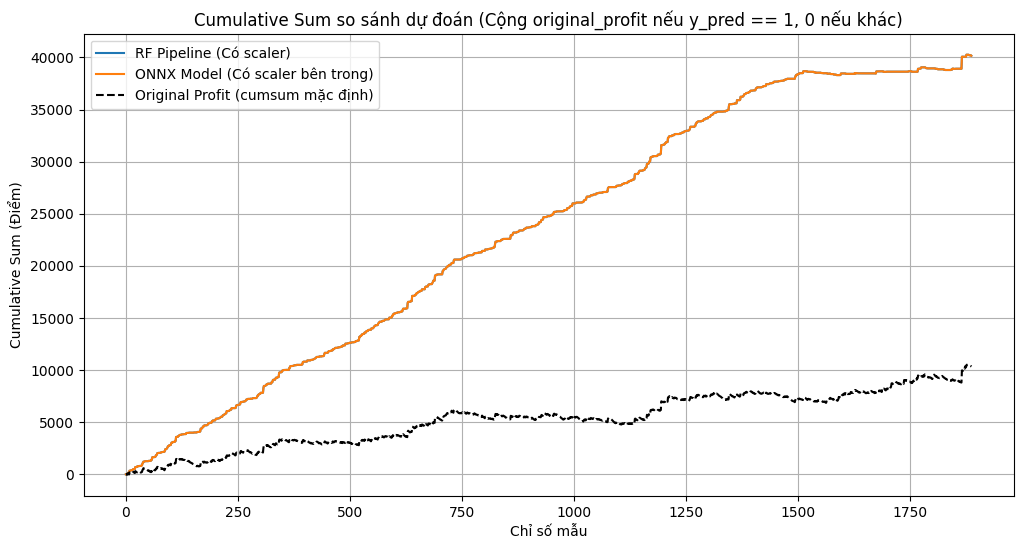

In [ ]:
# Giả sử biến data đã có sẵn, với X và y như đã chuẩn bị
X_full = data.drop("Profit", axis=1)
y_full = data["Profit"]

# 1. Dự đoán bằng model rf_pipeline (đã tích hợp scaler bên trong)
y_pred_rf = model.predict(X_full)
# Nếu dự đoán bằng 1, cộng original_profit; ngược lại, cộng 0
score_rf = np.where(y_pred_rf == 1, original_profit, 0)
cumsum_rf = np.cumsum(score_rf)

# 2. Dự đoán bằng model ONNX trên toàn bộ dataset (dữ liệu gốc chưa chuẩn hoá)
session = ort.InferenceSession(file_name)
input_name = session.get_inputs()[0].name

# Chuyển dữ liệu đầu vào sang NumPy array và ép kiểu về float32
X_full_np = X_full.to_numpy().astype(np.float32)

# Dự đoán từ model ONNX
onnx_pred = session.run(None, {input_name: X_full_np})[0]
onnx_pred = np.array(onnx_pred).flatten()
score_onnx = np.where(onnx_pred == 1, original_profit.to_numpy(), 0)
cumsum_onnx = np.cumsum(score_onnx)

# 3. Tính cumulative sum mặc định từ original_profit
cumsum_y = np.cumsum(original_profit.to_numpy())

# Plot so sánh
plt.figure(figsize=(12, 6))
plt.plot(cumsum_rf, label="RF Pipeline (Có scaler)")
plt.plot(cumsum_onnx, label="ONNX Model (Có scaler bên trong)")
plt.plot(cumsum_y, label="Original Profit (cumsum mặc định)", linestyle='--', color='k')
plt.xlabel("Chỉ số mẫu")
plt.ylabel("Cumulative Sum (Điểm)")
plt.title("Cumulative Sum so sánh dự đoán (Cộng original_profit nếu y_pred == 1, 0 nếu khác)")
plt.legend()
plt.grid(True)
plt.show()


## Phần 6 - Kiểm thử: Tập test

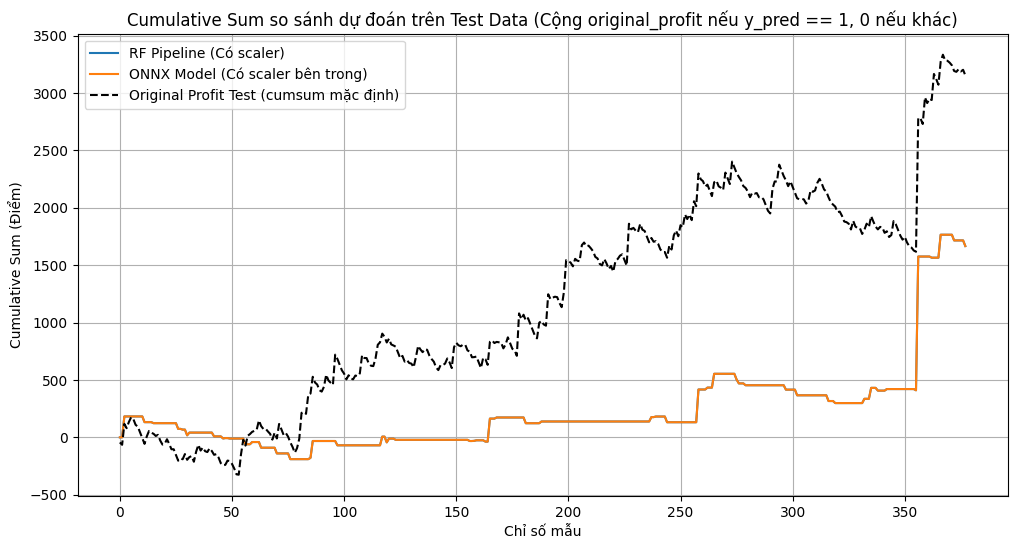

In [ ]:

# Giả sử X_test, y_test đã được tách từ dữ liệu ban đầu và original_profit_test được lấy theo index:
original_profit_test = original_profit.loc[y_test.index]

# 1. Dự đoán bằng model rf_pipeline (đã tích hợp scaler bên trong)
y_pred_rf = model.predict(X_test)
score_rf = np.where(y_pred_rf == 1, original_profit_test, 0)
cumsum_rf = np.cumsum(score_rf)

# 2. Dự đoán bằng model ONNX trên dữ liệu Test (dữ liệu gốc chưa chuẩn hoá)
session = ort.InferenceSession(file_name)
input_name = session.get_inputs()[0].name

X_test_np = X_test.to_numpy().astype(np.float32)
onnx_pred = session.run(None, {input_name: X_test_np})[0]
onnx_pred = np.array(onnx_pred).flatten()
score_onnx = np.where(onnx_pred == 1, original_profit_test.to_numpy(), 0)
cumsum_onnx = np.cumsum(score_onnx)

# 3. Tính cumulative sum mặc định từ original_profit_test
cumsum_y = np.cumsum(original_profit_test.to_numpy())

# Plot so sánh trên dữ liệu Test
plt.figure(figsize=(12, 6))
plt.plot(cumsum_rf, label="RF Pipeline (Có scaler)")
plt.plot(cumsum_onnx, label="ONNX Model (Có scaler bên trong)")
plt.plot(cumsum_y, label="Original Profit Test (cumsum mặc định)", linestyle='--', color='k')
plt.xlabel("Chỉ số mẫu")
plt.ylabel("Cumulative Sum (Điểm)")
plt.title("Cumulative Sum so sánh dự đoán trên Test Data (Cộng original_profit nếu y_pred == 1, 0 nếu khác)")
plt.legend()
plt.grid(True)
plt.show()

## Phần 6 - So Sánh: Datetime các mẫu dự đoán lệch

In [ ]:
import numpy as np
import onnxruntime as ort

def compare_model_vs_onnx(sklearn_model, onnx_path, X_test, threshold=0.5, return_details=False):
    """
    So sánh y_pred = model.predict(X_test) với y_onx = ONNXRuntime(X_test).
    Nếu ONNX trả về probabilities thay vì labels, bạn có thể dùng threshold để convert.

    Trả về:
      diff_idx: mảng các chỉ số i sao cho y_py[i] != y_onx[i]
      (tuỳ chọn) y_py, y_onx nếu return_details=True
    """
    # 1) Python-side prediction
    y_py = sklearn_model.predict(X_test)
    y_py = np.where(y_py == -1, 0, y_py).astype(int)

    # 2) ONNX-side prediction
    sess = ort.InferenceSession(onnx_path)
    inp = sess.get_inputs()[0].name
    X_np = X_test.to_numpy().astype(np.float32)
    onx_out = sess.run(None, {inp: X_np})

    # Nếu ONNX trả về [labels, probs] thì giả định labels là out[0]
    # Còn nếu trả về probs thì out[-1] hoặc cần threshold:
    if onx_out[0].dtype in (np.int64, np.int32):
        y_onx = onx_out[0].ravel().astype(y_py.dtype)
    else:
        # giả sử output probs ở vị trí 1
        probs = onx_out[1].ravel()
        y_onx = (probs >= threshold).astype(y_py.dtype)

    # 3) Tìm diff
    diff_idx = np.where(y_py != y_onx)[0]

    if return_details:
        return diff_idx, y_py, y_onx
    return diff_idx

# --- Sử dụng trên tập test ---
diff_idx, y_py, y_onx = compare_model_vs_onnx(
    sklearn_model   = model_cat,
    onnx_path       = file_name,
    X_test          = X_test,
    return_details  = True
)

print(f"Số sample khác: {len(diff_idx)}")
print("Các chỉ số mismatch:", diff_idx[:10], "…")
print("Datetime mismatch:", X_test.index[diff_idx].tolist())

# In ví dụ chi tiết cho 5 mismatch đầu
for i in diff_idx[:5]:
    print(f"  idx={i}, datetime={X_test.index[i]}, py={y_py[i]}, onx={y_onx[i]}")


Số sample khác: 0
Các chỉ số mismatch: [] …
Datetime mismatch: []
